In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
try:
    from imutils import paths
except ImportError:
    !pip install imutils
    from imutils import paths
    
import matplotlib.pyplot as plt
%matplotlib inline

# dataset download api command
# kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Lets start by analyzing the number of images in each class for the training set

In [2]:
PARENT_DIR = "./chest_xray/"
pneumonia_train = list(paths.list_images("./chest_xray/train/PNEUMONIA/"))
normal_train = list(paths.list_images("./chest_xray/train/NORMAL/"))
print(len(pneumonia_train))
print(len(normal_train))

3875
1341


### 1. Explanatory Analysis
Let's go into each class and randomly display some images to get an idea of how they look. But first lets make a function to do this for us.

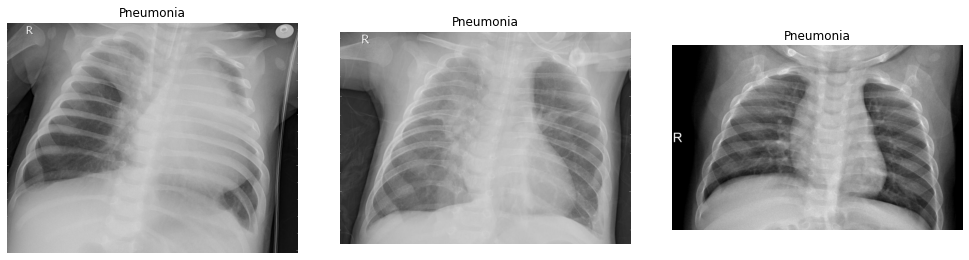

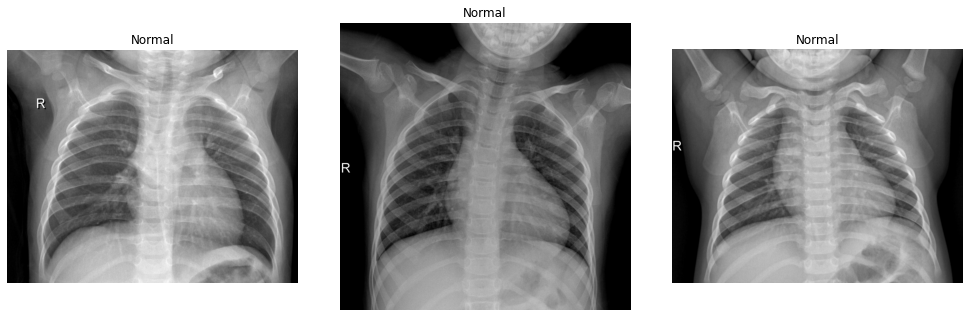

In [3]:
# define classes
columns = 3
classes = {
    "Pneumonia":[cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.sample(pneumonia_train, columns)], 
    "Normal": [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.sample(normal_train, columns)]
}

# this method displays images for two classes above and below
def display(classes, columns, read_as_rgb=True, cmap=None):
    for _class in classes:
        #print(random_images)
        fig, axes = plt.subplots(nrows=1, ncols=columns, figsize=(14, 10), squeeze=False)
        fig.tight_layout()
        for l in range(1):
            for m, img in enumerate(classes[_class]):
                axes[l][m].imshow(img, cmap=cmap)
                axes[l][m].axis("off")
                axes[l][m].set_title(_class)
    # done displaying
    
# display images
display(classes, columns)

### Image Preprocessing


As we can see from the above images, some have low contrast and for some chest cavity is little blurry. Let us do some preprocessing that will bring up the contrast in the images. The preferred approach for this is to histogram equalize the images in the Value channel of HSV color space. See the below images before and after histogram equalization to see the differnce in the information.

                                        Before Histogram Equalization
![alt text](notebook_images/hist_eq_before.png)
                                        



                                        After Histogram Equalization
![alt text](notebook_images/hist_eq_after.png )
                                 
We can clrealy see how histogram equalization has brought up the contrast in the grayscale image and is much clearer to see. So we will perform histogram equalization as one of the preprocessing steps to our current images.

Let's make a fucntion for the preprocessing of images and display them together to see if we have any improvement after preprocessing.

In [4]:
def preprocess(image, input_mode="grayscale", reshape=True, **kwargs):
    
    sharp = kwargs.get("sharp", True)
    hist = kwargs.get("hist", True)
    # convert to uint8 watch out after new definition
    img = image.astype(np.uint8)
    
    def _histogram_equalize(img, input_mode):
        # if the image is of bgr then equalize each channel and join back
        if input_mode == "bgr":
            B, G, R = cv2.split(img)
            B = cv2.equalizeHist(B)
            G = cv2.equalizeHist(G)
            R = cv2.equalizeHist(R)
            img = cv2.merge([B, G, R])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # if grayscale image
        elif input_mode == "grayscale":
            img = cv2.equalizeHist(img)
        return img
            
    def _sharp(img):
        sixma_x = 10
        img = cv2.addWeighted(
            img, 4, cv2.GaussianBlur(img, (0, 0), sixma_x), -4, 128 
        )
        return img
        
    if hist and not sharp:
        img = _histogram_equalize(img, input_mode=input_mode)
    elif sharp and not hist:
        img = _sharp(img)
    elif hist and sharp:
        img = _histogram_equalize(img, input_mode=input_mode)
        img = _sharp(img)

    if reshape:
        img = img.reshape(224, 224, 1)
    img = img/255.
    return img

From now on we will be converting all the images to grayscale and will do all preprocessing on them as there is not much information in the R,G,B channels.

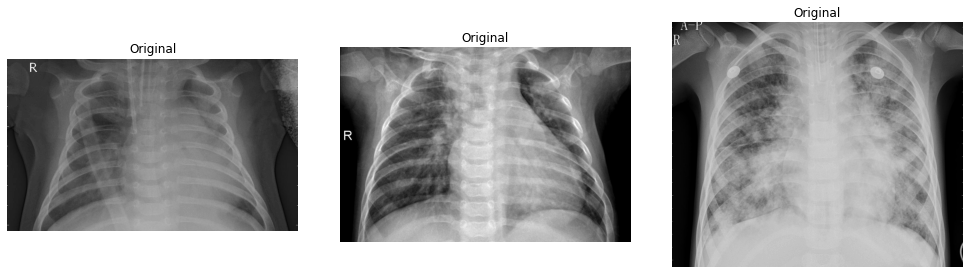

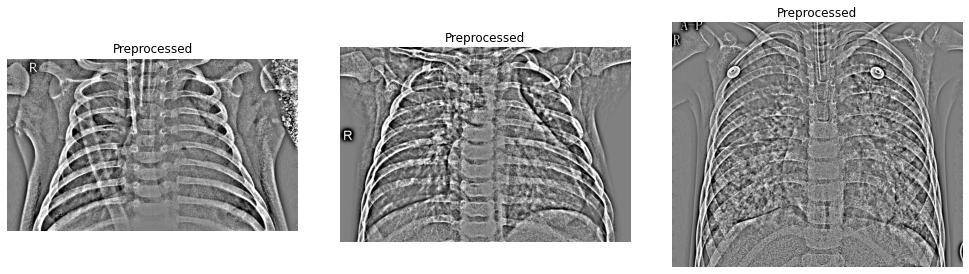

In [5]:
# get some random positive images
sample_positive = random.sample(pneumonia_train, 3)

pre_sharp = [preprocess(cv2.imread(img, 0), input_mode="grayscale", reshape=False, sharp=True, hist=True) for img in sample_positive]
# make a dictionary regular samples and preprocessed ones
classes = {
    "Original": [cv2.imread(img, 0) for img in sample_positive],
    "Preprocessed": [preprocess(cv2.imread(img, 0), input_mode="grayscale", reshape=False) for img in sample_positive],
    # "Deep": pre_sharp
} 

# display the images 
display(classes, 3, cmap="gray")

### 2. Data Preprocessing and Augumentation

In this section we will generate and standardize data to address class imbalance problem that we saw above (images of one class are less than each other)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

IM_WIDTH = 224
IM_HEIGHT = 224
BATCH_SIZE = 24
NB_CLASSES = 2

try:
    from imutils import paths
except ModuleNotFoundError:
    !pip install imutils
    from imutils import paths

_generator = ImageDataGenerator(
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=0.01,
    horizontal_flip=False,
    rotation_range=2.99,
)

Define the generators required for Training and Validation 

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
np.random.seed(255)
import os
os.environ["PYTHONHASHSEED"] = str(255)
import random
random.seed(255)

COLOR_MODE = "grayscale"

# generator for train and validation
_image_generator = ImageDataGenerator(
    # rescale=1./255,
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=0.01,
    horizontal_flip=False,
    rotation_range=2.99,
    preprocessing_function=preprocess
)

# train
_train_generator = _image_generator.flow_from_directory(
    directory="./chest_xray/train/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=True,
    seed=255,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)
_valid_generator = _test_generator.flow_from_directory(
    directory="./chest_xray/val/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=True,
    seed=255,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=16
)

# we don't need augumentation for validation and test, so we define a new generator
_test_generator = ImageDataGenerator(
    preprocessing_function=preprocess
)
"""
# validation
_valid = _test_generator.flow_from_directory(
    directory="./chest_xray/val/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=True,
    seed=255,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=16
)
"""


AUTOTUNE = tf.data.experimental.AUTOTUNE

_train = tf.data.Dataset.from_generator(
        lambda: _image_generator.flow_from_directory(
        directory="./chest_xray/train/",
        target_size=(IM_WIDTH, IM_HEIGHT),
        shuffle=True,
        seed=255,
        color_mode=COLOR_MODE,
        class_mode="categorical",
        batch_size=BATCH_SIZE
    ), 
    output_types=(tf.float32, tf.float32), 
    output_shapes = ([None, IM_WIDTH, IM_HEIGHT, 1], [None, NB_CLASSES])
)

_valid = tf.data.Dataset.from_generator(
    lambda: _test_generator.flow_from_directory(
        directory="./chest_xray/val/",
        target_size=(IM_WIDTH, IM_HEIGHT),
        shuffle=True,
        seed=255,
        color_mode=COLOR_MODE,
        class_mode="categorical",
        batch_size=16
    ),
    output_types=(tf.float32, tf.float32), 
    output_shapes = ([None, IM_WIDTH, IM_HEIGHT, 1], [None, NB_CLASSES])
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Model Definition and Training

Let us construct a CNN and train with above data

In [25]:
import tensorflow as tf

from tensorflow.keras import callbacks
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

In [45]:
class CustomNet(object):
    
    def __init__(self, height, width, channels, classes, parameter_scaling):
        self.height = height
        self.width = width
        self.channels = channels
        self.output_classes = classes
        self.scale = parameter_scaling
        
        self._build()
    
    def _build(self):
        
        input_shape = (self.height, self.width, self.channels)
        chan_dim = -1
        scale = self.scale
        
        _input = Input(shape=input_shape, name="Input-0")
        
        # model architecture
        # _model = Sequential()
        x = _input
    
        # 224x224
        # convolution 1
        x = Conv2D(filters=scale, kernel_size=(3, 3))(x)
        x = LeakyReLU(alpha=0.1)(x)
        # convolution 2
        x = Conv2D(2*scale, (3, 3))(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(rate=0.1)(x)
        
        # 112x112
        # convolution 3
        x = Conv2D(3*scale, (3, 3))(x)
        x = LeakyReLU(alpha=0.1)(x)
        # convolution 4
        x = Conv2D(4*scale, (3, 3))(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.1)(x)
        
        # 56x56
        # convolution 5
        x = Conv2D(5*scale, (3, 3))(x)
        x = LeakyReLU(alpha=0.1)(x)
        # convolution 6
        x = Conv2D(3*scale, (3, 3))(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.1)(x)
        """
        # 28x28
        # convolution 7
        x = Conv2D(6*scale, (3, 3))(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.1)(x)
        
        # 14x14
        # convolution 8
        x = Conv2D(7*scale, (3, 3))(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.1)(x)
        """
        
        # flattening layer
        x = Flatten()(x)
        
        # first dense layer
        x = Dense(units=5*scale)(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Dropout(0.5)(x)
        """
        # second dense layer
        x = Dense(units=7*scale)(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Dropout(0.5)(x)

        # third dense layer
        x = Dense(units=7*scale)(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Dropout(0.5)(x)
        """
        # output layer
        x = Dense(self.output_classes, activation="softmax")(x)
        
        _output = x
        
        self.model = Model(_input, _output)

In [49]:
LR = 1e-4
SCALE = 16
# BATCH_SIZE = 16
EPOCHS = 25
STEPS_PER_EPOCH = int(np.ceil(_train_generator.samples/BATCH_SIZE))
print(STEPS_PER_EPOCH)
VAL_PER_EPOCH = int(np.ceil(_valid_generator.samples/BATCH_SIZE))
print(VAL_PER_EPOCH)
# from tensorflow.python.framework import ops
# ops.reset_default_graph()


def lr_scheduler(epoch, lr):
    if epoch >= 21:
        return (1e-4)*0.25
    else:
        return lr
"""
    callbacks.TensorBoard(
        log_dir="tensorboard", write_graph=True, write_images=False    
    ),
"""
# define callbacks
_callbacks = [
    LearningRateScheduler(lr_scheduler)
]

# initiate model
nn = CustomNet(
    height=IM_HEIGHT, width=IM_WIDTH, channels=1, 
    classes=2, parameter_scaling=SCALE
)

# compile
nn.model.compile(
    loss="binary_crossentropy",optimizer=Adam(lr=LR), metrics=["accuracy"]
)

218
1


In [50]:
"""
from numba import cuda
cuda.select_device(0)
cuda.close()

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = False

session = InteractiveSession(config=config)
"""

'\nfrom numba import cuda\ncuda.select_device(0)\ncuda.close()\n\nfrom tensorflow.compat.v1 import ConfigProto\nfrom tensorflow.compat.v1 import InteractiveSession\n\nconfig = ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.8\nconfig.gpu_options.allow_growth = False\n\nsession = InteractiveSession(config=config)\n'

In [52]:
%%time

import tensorflow as tf
#with tf.device('/gpu:0'):
# start training

history = nn.model.fit(
    x=_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=_valid,
    validation_steps=16,
    callbacks=_callbacks,
    epochs=EPOCHS,
    verbose=1
)
"""

history = nn.model.fit_generator(
    _train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=_valid,
    validation_steps=_valid.samples,
    callbacks=_callbacks,
    epochs=EPOCHS,
    verbose=1
)
"""

Train for 218 steps, validate for 16 steps
Epoch 1/25
Found 5216 images belonging to 2 classes.
218/218 [==============================] - 89s 406ms/step - loss: 0.2970 - accuracy: 0.8725 - val_loss: 0.4316 - val_accuracy: 0.7500
Epoch 2/25
218/218 [==============================] - 69s 315ms/step - loss: 0.1467 - accuracy: 0.9413 - val_loss: 0.2900 - val_accuracy: 0.8750
Epoch 3/25
218/218 [==============================] - 69s 316ms/step - loss: 0.1259 - accuracy: 0.9526 - val_loss: 0.2207 - val_accuracy: 0.9375
Epoch 4/25
218/218 [==============================] - 71s 324ms/step - loss: 0.1069 - accuracy: 0.9592 - val_loss: 0.2365 - val_accuracy: 0.8750
Epoch 5/25
218/218 [==============================] - 69s 315ms/step - loss: 0.0919 - accuracy: 0.9617 - val_loss: 0.3460 - val_accuracy: 0.8125
Epoch 6/25
218/218 [==============================] - 69s 316ms/step - loss: 0.0881 - accuracy: 0.9664 - val_loss: 0.1584 - val_accuracy: 1.0000
Epoch 7/25
218/218 [=========================

'\n\nhistory = nn.model.fit_generator(\n    _train_generator,\n    steps_per_epoch=STEPS_PER_EPOCH,\n    validation_data=_valid,\n    validation_steps=_valid.samples,\n    callbacks=_callbacks,\n    epochs=EPOCHS,\n    verbose=1\n)\n'

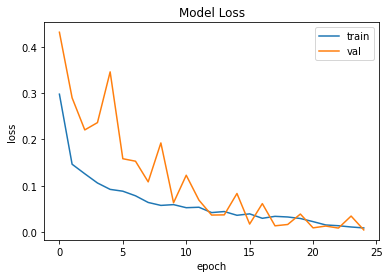

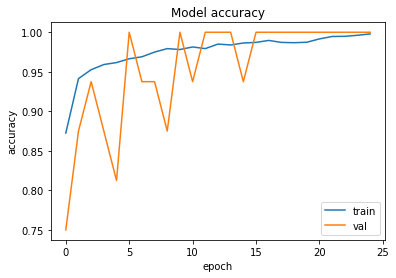

In [53]:
# Let us plot the loss and accuracy functions for both training and validation sets to see how our model behaved over training epochs
# PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline

# plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [54]:
# Let's define test data from the test generator that we used for validation also
# validation
_test = _test_generator.flow_from_directory(
    directory="./chest_xray/test/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=False,
    seed=255,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=1
)
print(_test.class_indices)

Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


In [55]:
test_loss, test_acc = nn.model.evaluate_generator(_test, steps=_test.samples, verbose=1)

print('val_loss:', test_loss)
print('val_cat_acc:', test_acc)

  ...
    to  
  ['...']
624/624 [==============================] - 6s 10ms/step - loss: 1.5453 - accuracy: 0.7901
val_loss: 1.5452824160728909
val_cat_acc: 0.7900641


In [56]:
# PREDICT
predictions = nn.model.predict_generator(_test, steps=_test.samples, verbose=1)
print(predictions.shape)
y_pred = np.argmax(predictions, axis=1)
y_test = _test.classes

624/624 [==============================] - 6s 10ms/step
(624, 2)


In [57]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

report = classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
print(report)

              precision    recall  f1-score   support

      NORMAL       0.97      0.45      0.62       234
   PNEUMONIA       0.75      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.74       624
weighted avg       0.83      0.79      0.77       624



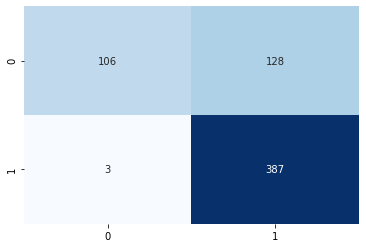

In [58]:
# heatmap
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, 
    fmt="d", 
    cbar = False, 
    cmap = plt.cm.Blues
)

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy score
print("Accuracy score of the model: {:.2f}".format(accuracy_score(y_test, y_pred)))

# f1 score
print("F1 score of the model: {:.2f}".format(f1_score(y_test, y_pred)))

# precision
print("Precision score of the model: {:.2f}".format(precision_score(y_test, y_pred)))

# recall
print("Recall score of the model: {:.2f}".format(recall_score(y_test, y_pred)))

Accuracy score of the model: 0.79
F1 score of the model: 0.86
Precision score of the model: 0.75
Recall score of the model: 0.99


## References

- https://towardsdatascience.com/histogram-equalization-5d1013626e64
- https://hypjudy.github.io/2017/03/19/dip-histogram-equalization/